In [1]:
%matplotlib inline
import sys
#sys.path.insert(0, '/home/space/kai/src/Viscid/')
#sys.path.insert(0, '/home/space/dominic/Viscid')

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import viscid
from viscid.plot import vpyplot as vlt
import h5py
import pandas as pd
import os
from mpl_toolkits import mplot3d

viscid.calculator.evaluator.enabled = True

%config InlineBackend.figure_format = 'retina'


project_dir="../data_m400/"


from scipy.signal import savgol_filter



#%matplotlib notebook







In [2]:

run = project_dir+"pfd.xdmf"
dir = project_dir
fp = viscid.load_file(run, force_reload=True)


In [3]:
#Functions

#Convenient Plotting
def make_plot(time, run, fldnames=["jy"], **kwargs):
    fig, ax = plt.subplots(len(fldnames), 1, figsize=(40,3*len(fldnames)))
    if not isinstance(ax, np.ndarray): ax = [ax]
    for i, fldname in enumerate(fldnames):
        # Hack around some inconsistencies with the field naming
        if run.endswith(".vpc"):
            map = {
                "bx_fc": "Magnetic Field X",
                "by_fc": "Magnetic Field Y",
                "bz_fc": "Magnetic Field Z",
                "jx": "Free Current Field X",
                "jy": "Free Current Field Y",
                
                "jz": "Free Current Field Z",
                "rho_nc": "Charge Density",
                "qn_nc_e": "Charge Density (ehydro)",
                "qn_nc_i": "Charge Density (Hhydro)",
                "jy_nc_e": "Current Density (ehydro) Y",
            }
        else:
            map = {
                "bx_fc": "hx_fc",
                "by_fc": "hy_fc",
                "bz_fc": "hz_fc",
                "qn_nc_e": "rho_nc_e",
                "qn_nc_i": "rho_nc_i",
            }
        vf = viscid.load_file(run, force_reload=True)
        vf.activate_time(time)
        _fldname = map[fldname] if fldname in map else fldname
        mid_val = 0
        
        vlt.plot(vf[_fldname], ax=ax[i], **kwargs);
        #plt.scatter(knots[0], knots[2], color = 'k')
        #vlt.plot(vf["psi"],style="contour",levels=50,colors='k', ax=ax[i], **kwargs);

#Cross Product (Can prob be replaced w/ something simpler??)
def VxB(v,B):
    x_comp = v[1]*B[2] - v[2]*B[1]
    y_comp = v[2]*B[0] - v[0]*B[2]
    z_comp = v[0]*B[1] - v[1]*B[0]
    
    vxb = np.array([x_comp, y_comp, z_comp])
    return vxb




# These values change depending on the run used
pt = np.array([0, 5, 350])
xl = np.array([0,-10,-200])
xh = xl + np.array([1600,20,400])
gdims = np.array([10240,1,2560])
dx = (xh - xl) / gdims

# Interp function for new Get_fields fuction 
def interp(a, pt):
    n = ((pt - xl)/dx).astype(int)
    return a[n[0],n[1],n[2]]


# New and improved Get_Fields
# Get_Fields is much faster, can do thousands of steps on the order of 1 min
# Does Require interp function above
def Get_Fields(r):
    fp.activate_time(t)
    Ex, Ey, Ez = fp['ex_ec'], fp['ey_ec'], fp['ez_ec']
    Bx, By, Bz = fp['hx_fc'], fp['hy_fc'], fp['hz_fc']
    
    
    r = np.array([r[0],0,r[2]]) # This Resets the y position to zero
    Ex = interp(Ex,r)
    Ey = interp(Ey,r)
    Ez = interp(Ez,r)
    Bx = interp(Bx,r)
    By = interp(By,r)
    Bz = interp(Bz,r)
    
    E = np.array([Ex, Ey, Ez])
    B = np.array([Bx, By, Bz])
    
    return E, B




# Boris Push.  Returns particle r, p, kinetic energy (k) at each step
def Push(r0,p0,n):
    #Define position (r) & momentum (p) 
    r = np.zeros((n+1,3))
    p = np.zeros((n+1,3))
    k = np.zeros((n+1,1))

    #Initial r & p
    r[0] = r0
    p[0] = p0
    k[0] = np.linalg.norm(p0)**2 / 2*m

    
    for i in range(n):

            E, B = Get_Fields(r[i])

            # Convenient rotation vector 
            b_rot = q*B*dt/2*m

            # 1st half of electric push
            p_1 = p[i] + q*E*dt/2

            # Rotation by VxB
            #p_2 = p_1 + 2*VxB((p_1 + VxB(p_1,b_rot))/(1+np.linalg.norm(b_rot)**2),b_rot)
            p_2 = p_1 + 2*np.cross((p_1 + np.cross(p_1, b_rot))/(1+np.linalg.norm(b_rot)**2),b_rot)

            # 2nd half of electric push 
            p[i+1] = p_2 + q*E*dt/2
            r[i+1] = r[i] + p[i+1]*dt/m
            k[i+1] = np.linalg.norm(p[i+1])**2 / 2*m
    
    
    
    
    return r,p,k

In [4]:
JEe = "ej=(jx_nc_e*ex_ec + jy_nc_e*ey_ec + jz_nc_e*ez_ec)"
JEex = "ejx=(jx_nc_e*ex_ec)"
JEey = "ejy=(jy_nc_e*ey_ec)"
JEez = "ejz=(jz_nc_e*ez_ec)"


JE = "ej=((jx_nc_e + jx_nc_i)*ex_ec + (jy_nc_e + jy_nc_i)*ey_ec + (jz_nc_e + jz_nc_i)*ez_ec)"
JEx = "ejx=(jx_nc_e + jx_nc_i)*ex_ec"
JEy = "ejy=(jy_nc_e + jy_nc_i)*ey_ec"
JEz = "ejz=(jz_nc_e + jz_nc_i)*ez_ec"

# Parallel component of J and E
JPar = "JPar = (jx_nc_e*hx_fc + jy_nc_e*hy_fc + jz_nc_e*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2)**0.5)"
EPar = "EPar = (ex_ec*hx_fc + ey_ec*hy_fc + ez_ec*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2)**0.5)"

# Parallel contribution to J.E that does NOT depend on sign of mag field
JEPar = "JE Par =  (((jx_nc_e + 0*jx_nc_i)*ex_ec)*(hx_fc**2) + ((jy_nc_e + 0*jy_nc_i)*ey_ec)*(hy_fc**2) + ((jz_nc_e + 0*jz_nc_i)*ez_ec)*(hz_fc**2)) / (hx_fc**2 + hy_fc**2 + hz_fc**2) "
JEPerp = "JE perp =  ((jx_nc_e + jx_nc_i)*ex_ec + (jy_nc_e + jy_nc_i)*jy_nc_e*ey_ec + (jz_nc_e + jz_nc_i)*jz_nc_e*ez_ec) - ((((jx_nc_e + 0*jx_nc_i)*ex_ec)*(hx_fc**2) + ((jy_nc_e + 0*jy_nc_i)*ey_ec)*(hy_fc**2) + ((jz_nc_e + 0*jz_nc_i)*ez_ec)*(hz_fc**2)) / (hx_fc**2 + hy_fc**2 + hz_fc**2)) "


EyPrime = "Ey' = ey_ec + (jz_nc_e * hx_fc)/rho_nc_e - (jx_nc_e * hz_fc)/rho_nc_e "

Te_ParPerp = "Te Par/TPerp - 1 = -1 + ((-1/rho_nc_e)*(hx_fc*txx_nc_e*hx_fc + hy_fc*tyy_nc_e*hy_fc + hz_fc*tzz_nc_e*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2))) / ((-1/rho_nc_e)*(txx_nc_e + tyy_nc_e + tzz_nc_e) - (-1/rho_nc_e)*(hx_fc*txx_nc_e*hx_fc + hy_fc*tyy_nc_e*hy_fc + hz_fc*tzz_nc_e*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2)))"
Ti_ParPerp = "Ti Par/TPerp - 1 = -1 + ((1/rho_nc_i)*(hx_fc*txx_nc_i*hx_fc + hy_fc*tyy_nc_i*hy_fc + hz_fc*tzz_nc_i*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2))) / ((1/rho_nc_i)*(txx_nc_i + tyy_nc_i + tzz_nc_i) - (1/rho_nc_i)*(hx_fc*txx_nc_i*hx_fc + hy_fc*tyy_nc_i*hy_fc + hz_fc*tzz_nc_i*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2)))"



uB = "uB = (hx_fc)**2 + (hy_fc)**2 + (hz_fc)**2"
sdcsuE = "uE = (ex_ec)**2 + (ey_ec)**2 + (ez_ec)**2"

JEi = "ej=(jx_nc_i*ex_ec + jy_nc_i*ey_ec + jz_nc_i*ez_ec)"

n = "n = rho_nc_e  + rho_nc_i"
Tex = "Te = (txx_nc_e + 0*tyy_nc_e + 0*tzz_nc_e)/3"
Tey = "Te = (0*txx_nc_e + tyy_nc_e + 0*tzz_nc_e)/3"
Tez = "Te = (0*txx_nc_e + 0*tyy_nc_e + tzz_nc_e)/3"

Te_Par = "Te Parallel = (-1/rho_nc_e)*(hx_fc*txx_nc_e*hx_fc + hy_fc*tyy_nc_e*hy_fc + hz_fc*tzz_nc_e*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2))"
Te_Perp = "Te Perp = (-1/rho_nc_e)*(txx_nc_e + tyy_nc_e + tzz_nc_e) - (-1/rho_nc_e)*(hx_fc*txx_nc_e*hx_fc + hy_fc*tyy_nc_e*hy_fc + hz_fc*tzz_nc_e*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2))"

Ti_Par = "Ti Parallel = (hx_fc*txx_nc_i*hx_fc + hy_fc*tyy_nc_i*hy_fc + hz_fc*tzz_nc_i*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2))"
Ti_Perp = "Ti Perp = (txx_nc_i + tyy_nc_i + tzz_nc_i) - (hx_fc*txx_nc_i*hx_fc + hy_fc*tyy_nc_i*hy_fc + hz_fc*tzz_nc_i*hz_fc) / ((hx_fc**2 + hy_fc**2 + hz_fc**2))"

fld = Te_Par



/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad('y')
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:214: MatplotlibDeprecationWarning: 
The get_rows_columns function was depreca

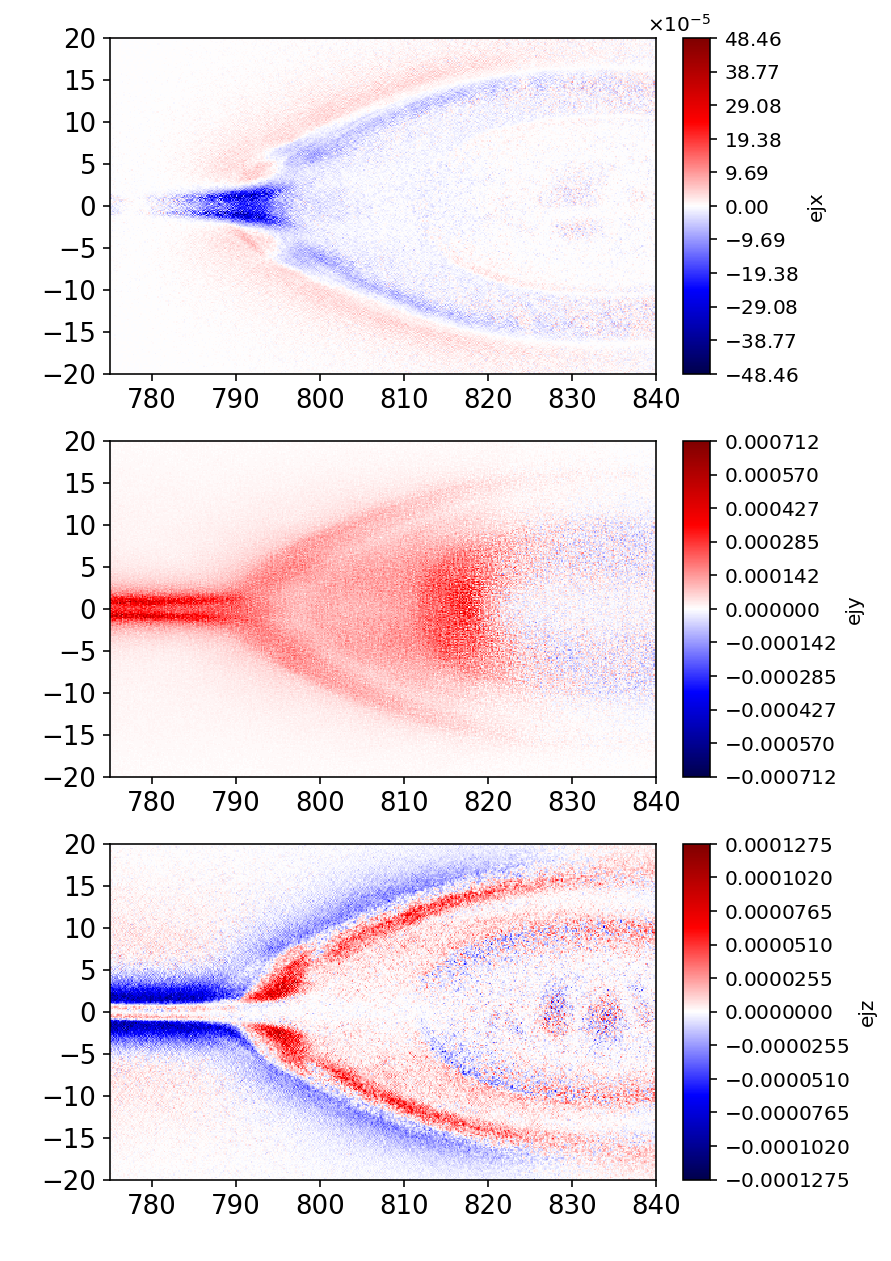

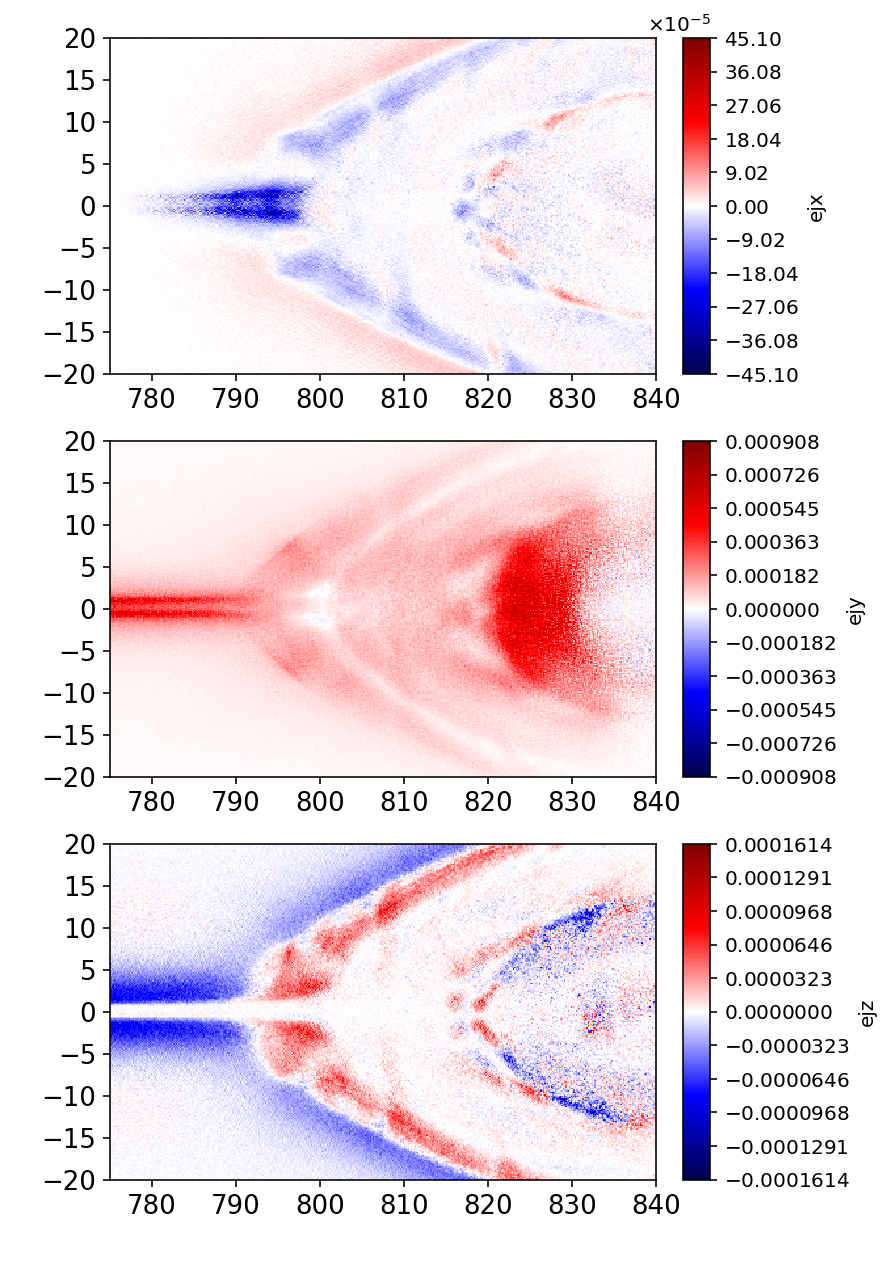

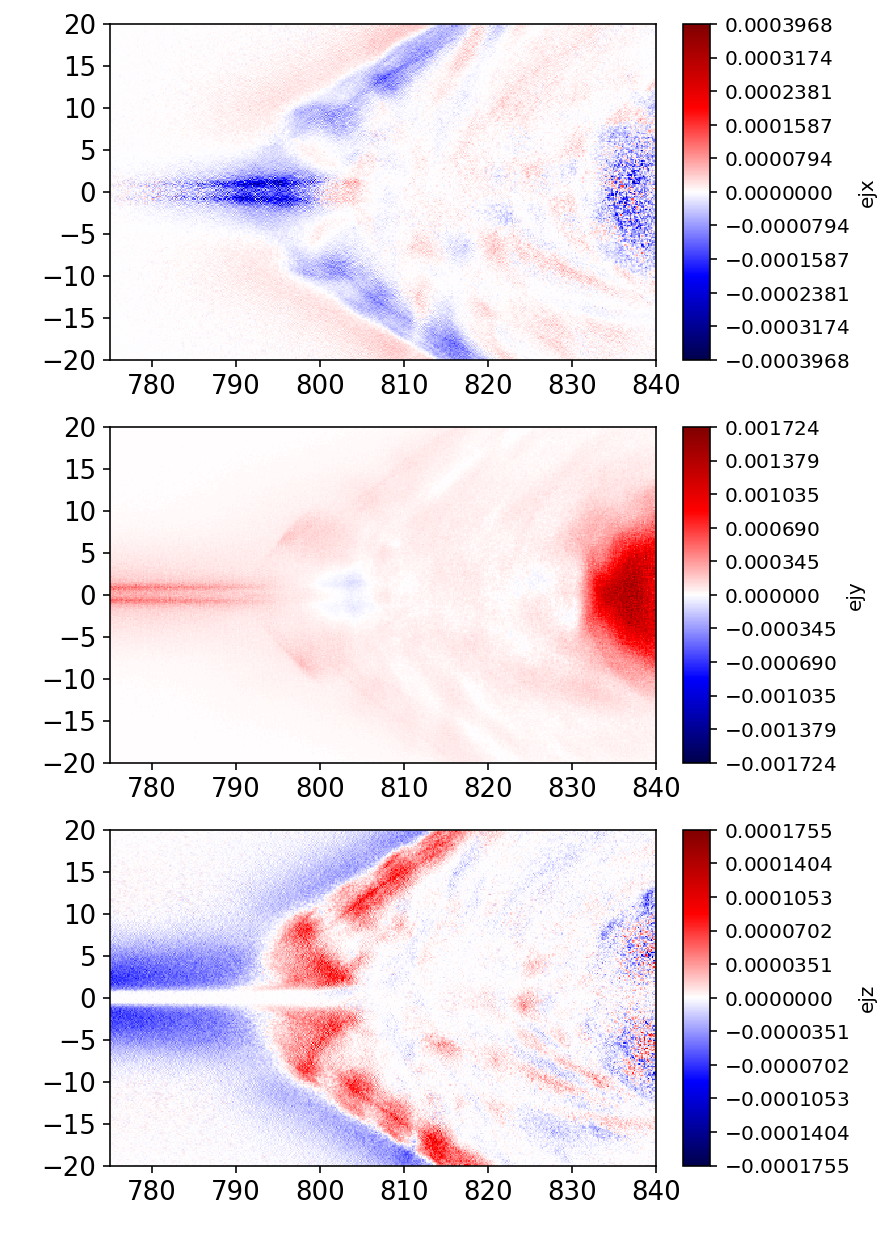

In [11]:
def plot(time, run, fldnames=["jy"], **kwargs):
    fig, ax = plt.subplots(len(fldnames), 1, figsize=(10,3.5*len(fldnames)))
    #if not isinstance(ax, np.ndarray): ax = [ax]
    for i, fldname in enumerate(fldnames):

        vf = viscid.load_file(run, force_reload=True)
        vf.activate_time(time)
        
        vlt.plot(vf[fldname], ax=ax[i], **kwargs);
        plt.xlabel(' ')
        plt.ylabel(' ')
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)
        
selection = "x=775f:840f, z=-20f:20f"
plot(16, run, [JEx,JEy,JEz],cmap = 'seismic',symmetric=True,selection = selection)
plot(17, run, [JEx,JEy,JEz],cmap = 'seismic',symmetric=True,selection = selection)
plot(18, run, [JEx,JEy,JEz],cmap = 'seismic',symmetric=True,selection = selection)


In [5]:
#%%timeit
#%matplotlib notebook
# Changing E and B with position

## This takes a while but seems to work 
## Should adjust dt and n around a bit 

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

t = 17
#vf = viscid.load_file(run, force_reload=True)
#vf.activate_time(t)





m = 1
q = -1

dt = 0.1

xs = 2.2
ys = 0.5
zs = 0.5

x = 778.5
y = 0
z = 0

px = 0
py = 0
pz = 0
s = 0
pxs = 0
pys = 0
#r0 = np.array([775+xs,0,0+zs]) 
#p0 = np.array([0,0,0]) 

# Single Position, multiple velocities
r0 = np.array([x,0,0]) 
p0 = np.array([px,py,pz]) 

r1 = np.array([x+xs,y,z])
p1 = np.array([px+1*pxs,py+1*pys,pz])

r2 = np.array([x+2*xs,y,z]) 
p2 = np.array([px+2*pxs,py+2*pys,pz]) 


r3 = np.array([x+3*xs,y,z])
p3 = np.array([px+3*pxs,py+3*pys,pz])

r4 = np.array([x+4*xs,y,z])
p4 = np.array([px+4*pxs,py+4*pys,pz])









n = 2000
r,p,k = Push(r0,p0,n)
r1,p1,k1 = Push(r1,p1,n)
r2,p2,k2 = Push(r2,p2,n)
r3,p3,k3 = Push(r3,p3,n)
r4,p4,k4 = Push(r4,p4,n)


In [22]:
#%%timeit
#%matplotlib notebook
# Changing E and B with position

## This takes a while but seems to work 
## Should adjust dt and n around a bit 

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

t = 17
#vf = viscid.load_file(run, force_reload=True)
#vf.activate_time(t)





m = 1
q = -1

dt = 0.1

xs = 2.2
ys = 0.5
zs = 0.5

x = 805
y = 0
z = 17

px = 0.15
py = 0
pz = 0.15
s = 0
pxs = 0
pys = 0
#r0 = np.array([775+xs,0,0+zs]) 
#p0 = np.array([0,0,0]) 

# Single Position, multiple velocities
r0 = np.array([x,y,z]) 
p0 = np.array([px,py,pz]) 

r1 = np.array([x+xs,y,z])
p1 = np.array([px,py,pz])

r2 = np.array([x+2*xs,y,z]) 
p2 = np.array([px+2*pxs,py+2*pys,pz]) 


r3 = np.array([x+3*xs,y,z])
p3 = np.array([px+3*pxs,py+3*pys,pz])

r4 = np.array([x+4*xs,y,z])
p4 = np.array([px+4*pxs,py+4*pys,pz])









n = 2000
r,p,k = Push(r0,p0,n)
#r1,p1,k1 = Push(r1,p1,n)
#r2,p2,k2 = Push(r2,p2,n)
#r3,p3,k3 = Push(r3,p3,n)
#r4,p4,k4 = Push(r4,p4,n)


/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad('y')
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:214: MatplotlibDeprecationWarning: 
The get_rows_columns function was depreca

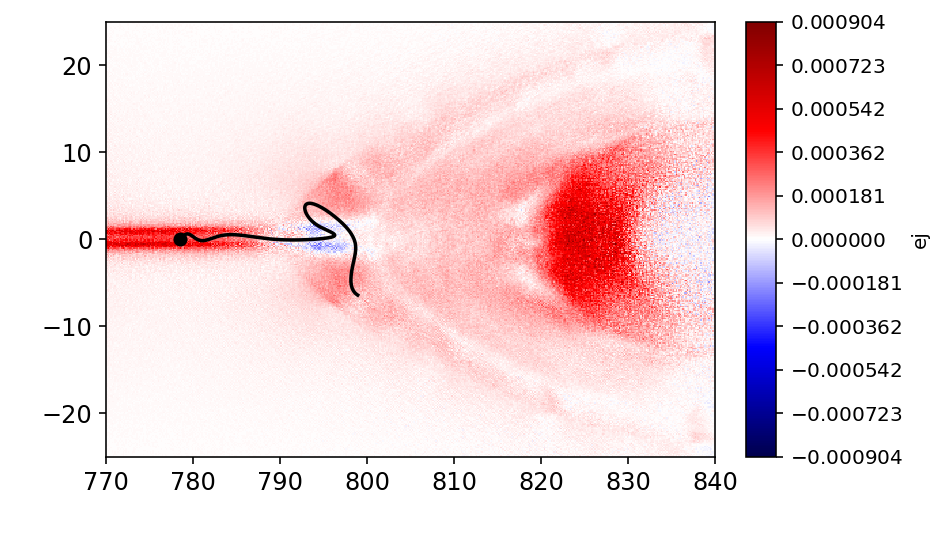

In [6]:
fld = JE

fp.activate_time(17)

plt.figure(figsize=(10,4))
plt.subplot(1,1,1)
vlt.plot(fp[fld], cmap = "seismic", symmetric = "True")
#vlt.plot(fp["psi"],style="contour",levels=50,colors='k', ax=ax[i], **kwargs);
plt.axis("image")
plt.xlim(770,840)
plt.ylim(-25,25)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel(' ')
plt.ylabel(' ')

end = 1700
plt.plot(r[0:end,0],r[0:end,2], 'black')
plt.plot(r[0,0],r[0,2], marker = 'o', color = 'black')

#plt.plot(r1[0:end,0],r1[0:end,2], 'blue')
#plt.plot(r1[0,0],r1[0,2], marker = 'o', color = 'blue')

#plt.plot(r2[0:end,0],r2[0:end,2], 'violet')
#plt.plot(r2[0,0],r2[0,2], marker = 'o', color = 'violet')

#plt.plot(r3[0:end,0],r3[0:end,2], 'red')
#plt.plot(r3[0,0],r3[0,2], marker = 'o', color = 'red')

#plt.plot(r4[0:end,0],r4[0:end,2], 'green')
#plt.plot(r4[0,0],r4[0,2], marker = 'o', color = 'green')


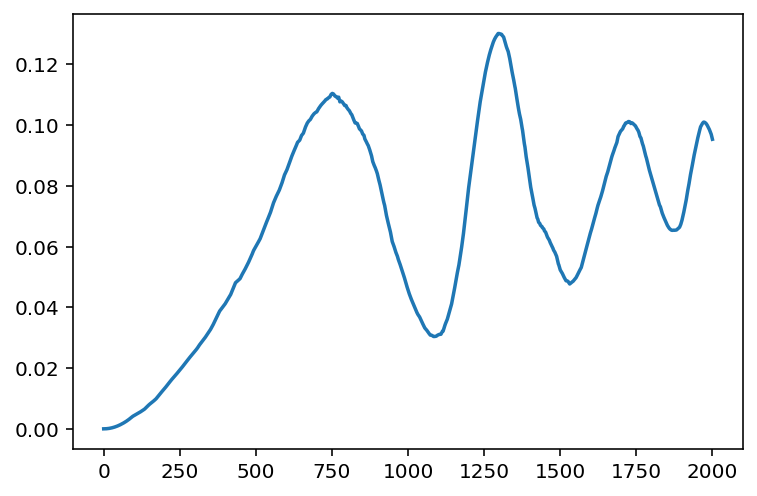

In [14]:
plt.plot(k)

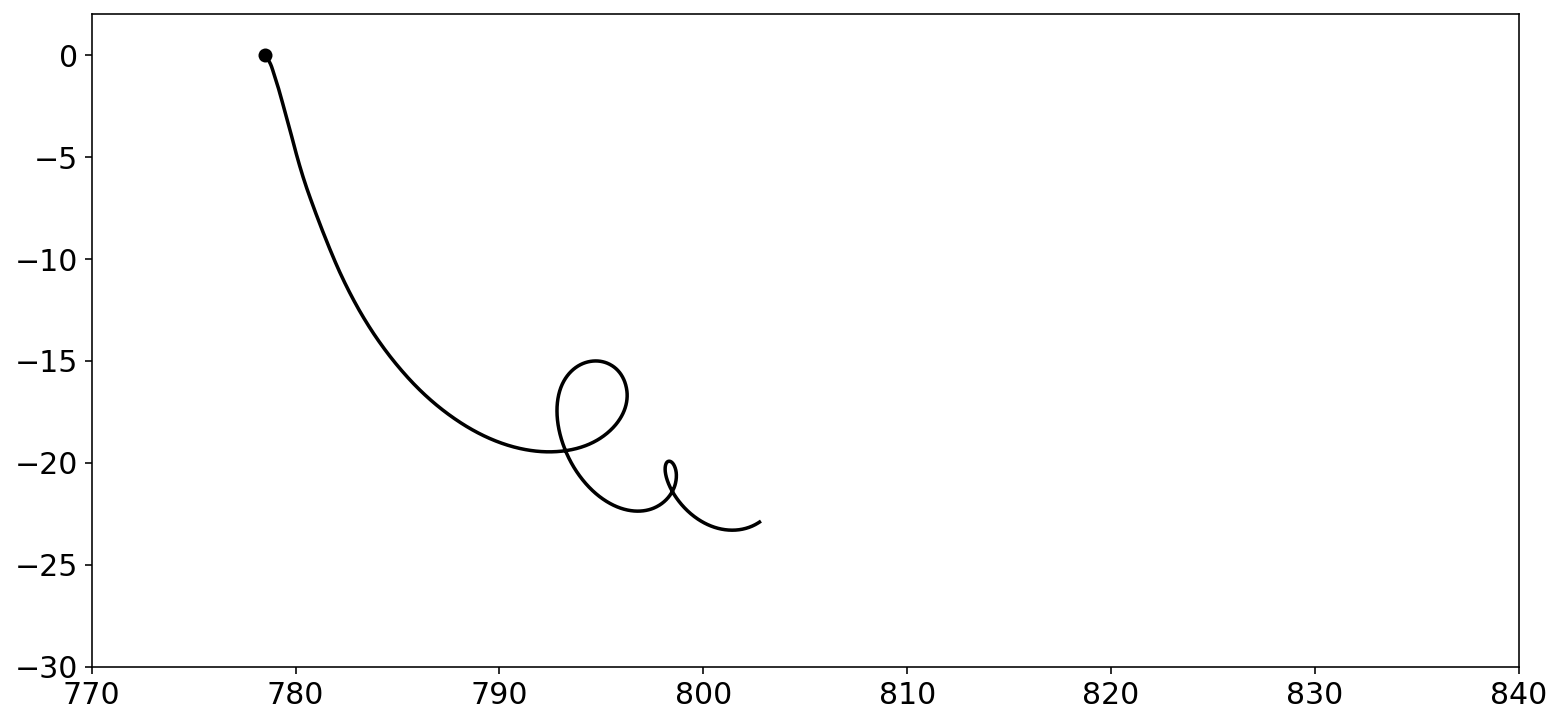

In [15]:
fld = JE

fp.activate_time(17)

plt.figure(figsize=(14,6))
plt.subplot(1,1,1)
#vlt.plot(fp[fld], cmap = "seismic", symmetric = "True")
#vlt.plot(fp["psi"],style="contour",levels=50,colors='k', ax=ax[i], **kwargs);
plt.axis("image")
plt.xlim(770,840)
plt.ylim(-30,2)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

end = 1800
plt.plot(r[0:end,0],r[0:end,1], 'black')
plt.plot(r[0,0],r[0,1], marker = 'o', color = 'black')

#plt.plot(r1[0:end,0],r1[0:end,1], 'blue')
#plt.plot(r1[0,0],r1[0,1], marker = 'o', color = 'blue')

#plt.plot(r2[0:end,0],r2[0:end,1], 'violet')
#plt.plot(r2[0,0],r2[0,1], marker = 'o', color = 'violet')

#plt.plot(r3[0:end,0],r3[0:end,1], 'red')
#plt.plot(r3[0,0],r3[0,1], marker = 'o', color = 'red')

#plt.plot(r4[0:end,0],r4[0:end,1], 'green')
#plt.plot(r4[0,0],r4[0,1], marker = 'o', color = 'green')


In [19]:

#%%timeit
#%matplotlib notebook
# Changing E and B with position

## This takes a while but seems to work 
## Should adjust dt and n around a bit 

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

t = 17
#vf = viscid.load_file(run, force_reload=True)
#vf.activate_time(t)





m = 1
q = -1

dt = 0.1

xs = 0.5
ys = 0.5
zs = 0.5

x = 778.5
y = 0
z = 0

px = 0
py = 0
pz = 0
s = 0
pxs = 0
pys = -0.1
#r0 = np.array([775+xs,0,0+zs]) 
#p0 = np.array([0,0,0]) 

# Single Position, multiple velocities
r0 = np.array([x,y,z]) 
p0 = np.array([px,py,pz]) 

r1 = np.array([x,y,z])
p1 = np.array([px+1*pxs,py+1*pys,pz])

r2 = np.array([x,y,z]) 
p2 = np.array([px+2*pxs,py+2*pys,pz]) 


r3 = np.array([x,y,z])
p3 = np.array([px+3*pxs,py+3*pys,pz])

r4 = np.array([x,y,z])
p4 = np.array([px+4*pxs,py+4*pys,pz])

r5 = np.array([x,y,z])
p5 = np.array([px+5*pxs,py+5*pys,pz])

r6 = np.array([x,y,z])
p6 = np.array([px+6*pxs,py+6*pys,pz])

r7 = np.array([x,y,z])
p7 = np.array([px+7*pxs,py+7*pys,pz])

r8 = np.array([x,y,z])
p8 = np.array([px+8*pxs,py+8*pys,pz])

r9 = np.array([x,y,z])
p9 = np.array([px+9*pxs,py+9*pys,pz])








n = 2000
r,p,k = Push(r0,p0,n)
r1,p1,k1 = Push(r1,p1,n)
r2,p2,k2 = Push(r2,p2,n)
r3,p3,k3 = Push(r3,p3,n)
r4,p4,k4 = Push(r4,p4,n)
r5,p5,k5 = Push(r5,p5,n)
r6,p6,k6 = Push(r6,p6,n)
r7,p7,k7 = Push(r7,p7,n)
r8,p8,k8 = Push(r8,p8,n)
r9,p9,k9 = Push(r9,p9,n)





In [20]:
#ALTERNATE --> p^2 (energy)
m = 1
list = np.array([p,p1,p2,p3,p4,p5,p6,p7,p8,p9])  # length N
p_mag = np.zeros([len(p),1])
p1_mag = np.zeros([len(p),1])
p2_mag = np.zeros([len(p),1])
p3_mag = np.zeros([len(p),1])
p4_mag = np.zeros([len(p),1])
p5_mag = np.zeros([len(p),1])
p6_mag = np.zeros([len(p),1])
p7_mag = np.zeros([len(p),1])
p8_mag = np.zeros([len(p),1])
p9_mag = np.zeros([len(p),1])
p_avg = np.zeros([len(p),1])

vec_avg = np.zeros([len(p),3])
mag_vec_avg = np.zeros([len(p), 1])
ra = np.zeros([len(p), 1])
ord = np.zeros([len(p), 1])

## Start by getting p_mag[i = 0:n] for one particle
## Do same process for all particles.  p1_mag[], p2_mag[], etc.
for i in range(0,len(p)):
    p_mag[i] = np.linalg.norm(p[i])
    p1_mag[i] = np.linalg.norm(p1[i])
    p2_mag[i] = np.linalg.norm(p2[i])
    p3_mag[i] = np.linalg.norm(p3[i])
    p4_mag[i] = np.linalg.norm(p4[i])
    p5_mag[i] = np.linalg.norm(p5[i])
    p6_mag[i] = np.linalg.norm(p6[i])
    p7_mag[i] = np.linalg.norm(p7[i])
    p8_mag[i] = np.linalg.norm(p8[i])
    p9_mag[i] = np.linalg.norm(p9[i])
    
    # Sum of all 10 magnitudes SQUARED
    p_avg[i] = ((p_mag[i] + p1_mag[i] + p2_mag[i] + p3_mag[i] + p4_mag[i] + p5_mag[i] + p6_mag[i] + p7_mag[i] + p8_mag[i] + p9_mag[i])/1 )**2 / 2*m
    
    # Sum of all 10 vectors 
    vec_avg[i] = (p[i]+p1[i]+p2[i]+p3[i]+p4[i]+p5[i]+p6[i]+p7[i]+p8[i]+p9[i]) # Vector momentum of ensemble
    
    # Magnitude of sum of all 10 vctors SQUARED
    mag_vec_avg[i] = np.linalg.norm(vec_avg[i])**2 / 2*m # Bulk Convective energy
    
    # Define "Randomness" Ratio
    ra[i] = (mag_vec_avg[i] / p_avg[i])

    

/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:523: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad(masknan)
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:527: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  p.get_cmap().set_bad('y')
/home/d0118dominic/.local/lib/python3.8/site-packages/viscid/plot/vpyplot.py:214: MatplotlibDeprecationWarning: 
The get_rows_columns function was depreca

Text(0, 0.5, 'N')

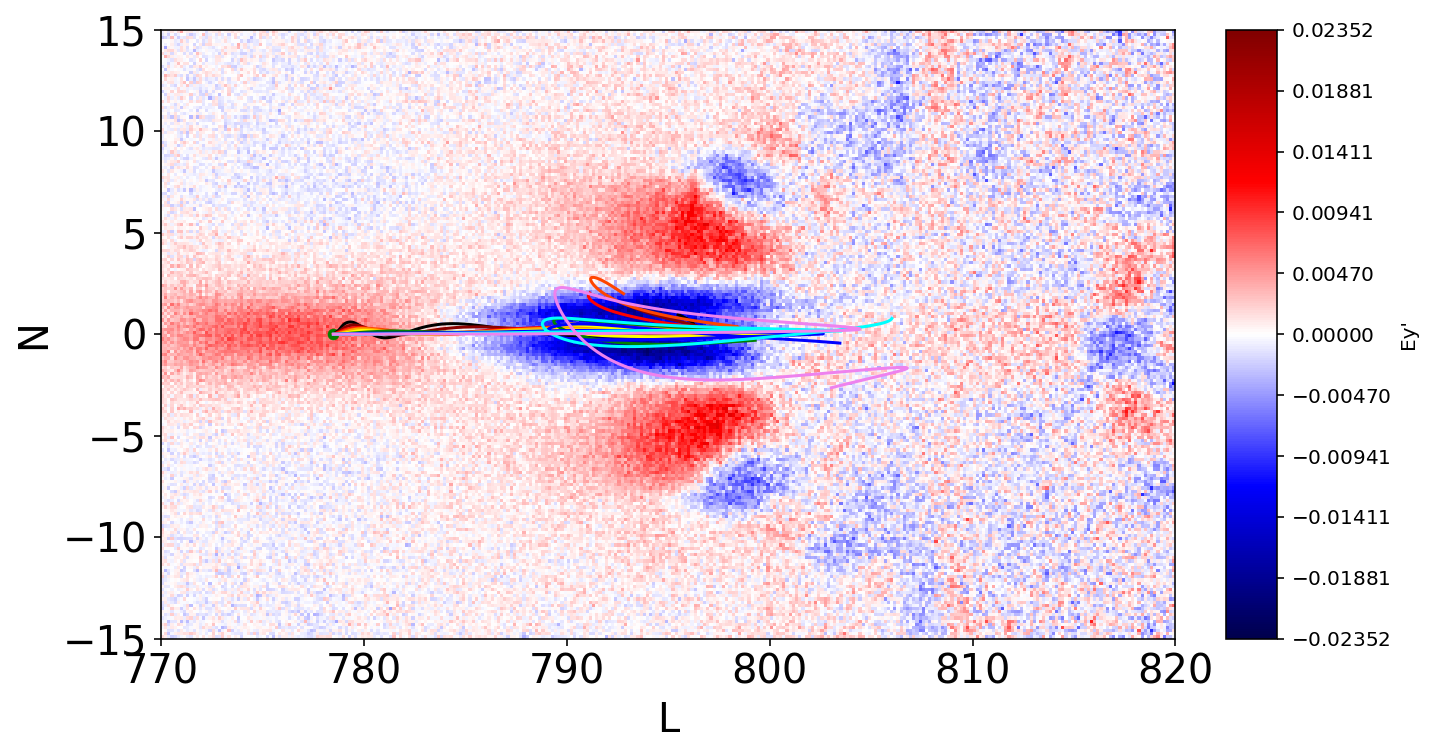

In [7]:
plt.figure(figsize=(10,10))
fld = EyPrime
vlt.plot(fp[fld], cmap = "seismic", symmetric = "True")
fnt = 20

plt.axis("image")
plt.xlim(770,820)
plt.ylim(-15,15)
plt.xticks(fontsize = fnt)
plt.yticks(fontsize = fnt)
lw = 1.5
end = 1100


plt.scatter(r[0,0],r[0,2], s = 30, c = 'green')

plt.plot(r[:end,0],r[:end,2], linewidth = lw, color =  'black')

plt.plot(r1[:end,0],r1[:end,2], linewidth = lw, color =  'darkred')

plt.plot(r2[:end,0],r2[:end,2],linewidth = lw,color= 'red')

plt.plot(r3[:end,0],r3[:end,2],linewidth = lw,color =  'orangered')


plt.plot(r4[:end,0],r4[:end,2],linewidth = lw,color =  'orange')

plt.plot(r5[:end,0],r5[:end,2],linewidth = lw,color =  'yellow')

plt.plot(r6[:end,0],r6[:end,2],linewidth = lw,color =  'green')

plt.plot(r7[:end,0],r7[:end,2],linewidth = lw,color =  'blue')

plt.plot(r8[:end,0],r8[:end,2],linewidth = lw,color =  'cyan')

plt.plot(r9[:end,0],r9[:end,2],linewidth = lw,color =  'violet')

plt.xlabel("L", fontsize = fnt)
plt.ylabel("N", fontsize = fnt)



Text(0, 0.5, 'M')

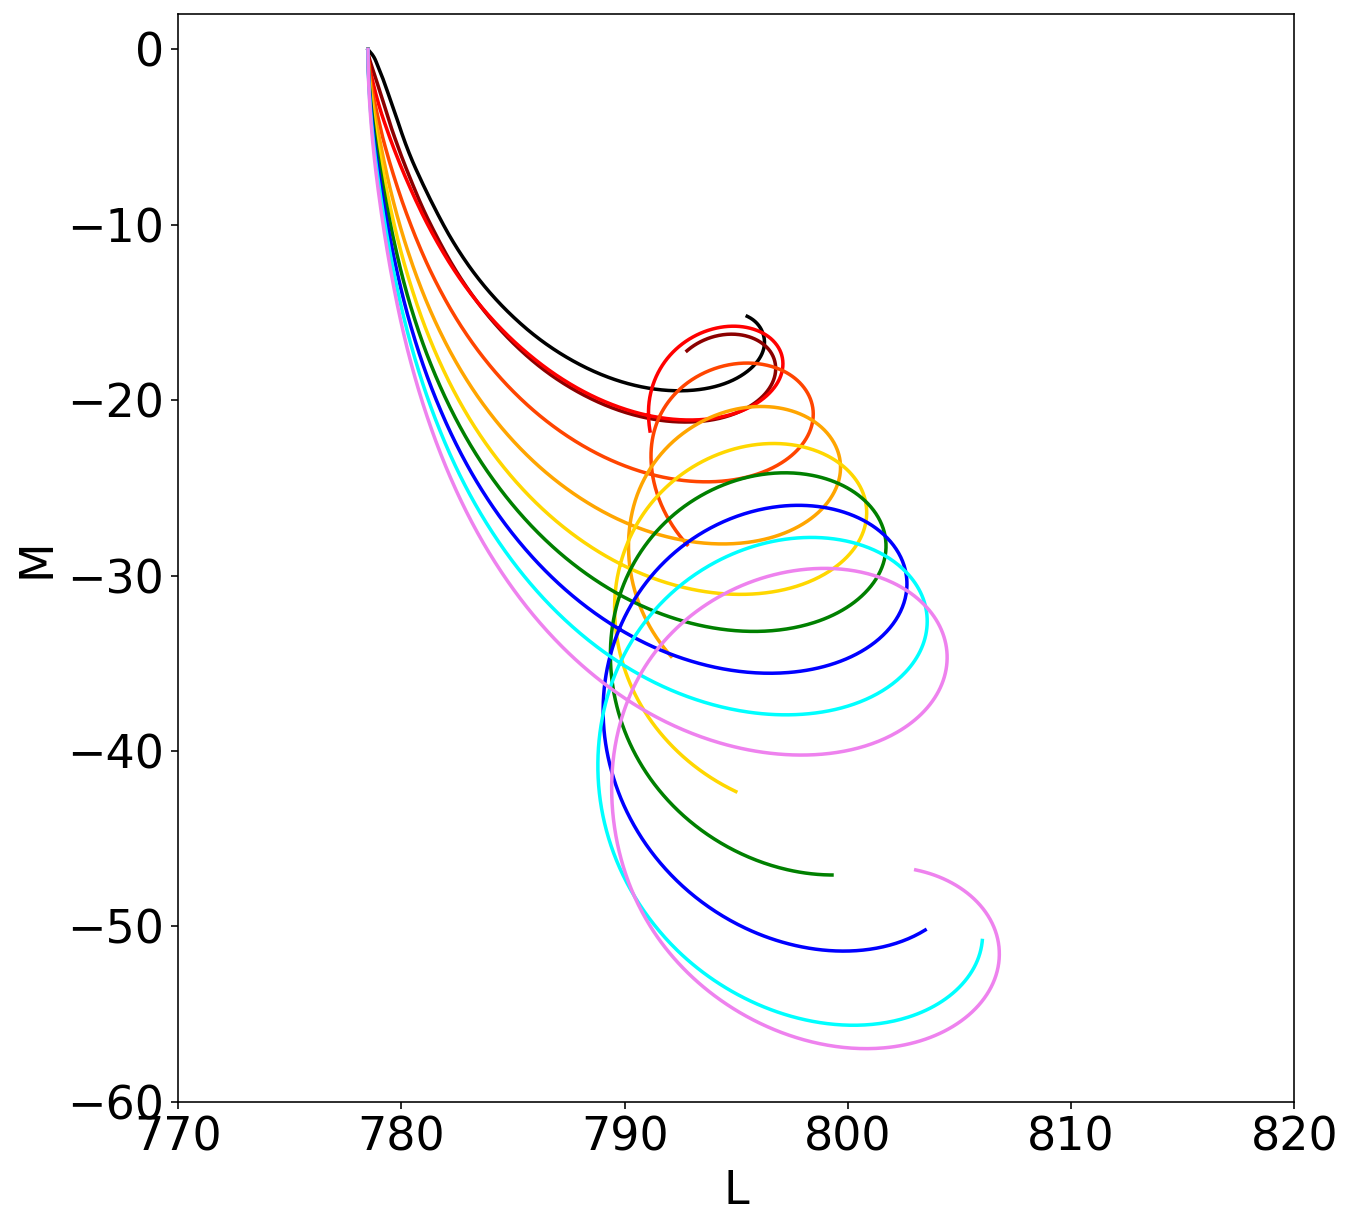

In [16]:
fnt = 23
plt.figure(figsize=(10,10))

plt.xlim(770,820)
plt.ylim(-60,2)
plt.xticks(fontsize = fnt)
plt.yticks(fontsize = fnt)

end =1100
plt.plot(r[:end,0],r[:end,1], 'black')
plt.plot(r1[:end,0],r1[:end,1], 'darkred')
plt.plot(r2[:end,0],r2[:end,1], 'red')
plt.plot(r3[:end,0],r3[:end,1], 'orangered')
plt.plot(r4[:end,0],r4[:end,1], 'orange')
plt.plot(r5[:end,0],r5[:end,1], 'gold')
plt.plot(r6[:end,0],r6[:end,1], 'green')
plt.plot(r7[:end,0],r7[:end,1], 'blue')
plt.plot(r8[:end,0],r8[:end,1], 'cyan')
plt.plot(r9[:end,0],r9[:end,1], 'violet')

plt.xlabel("L", fontsize = fnt)
plt.ylabel("M", fontsize = fnt)


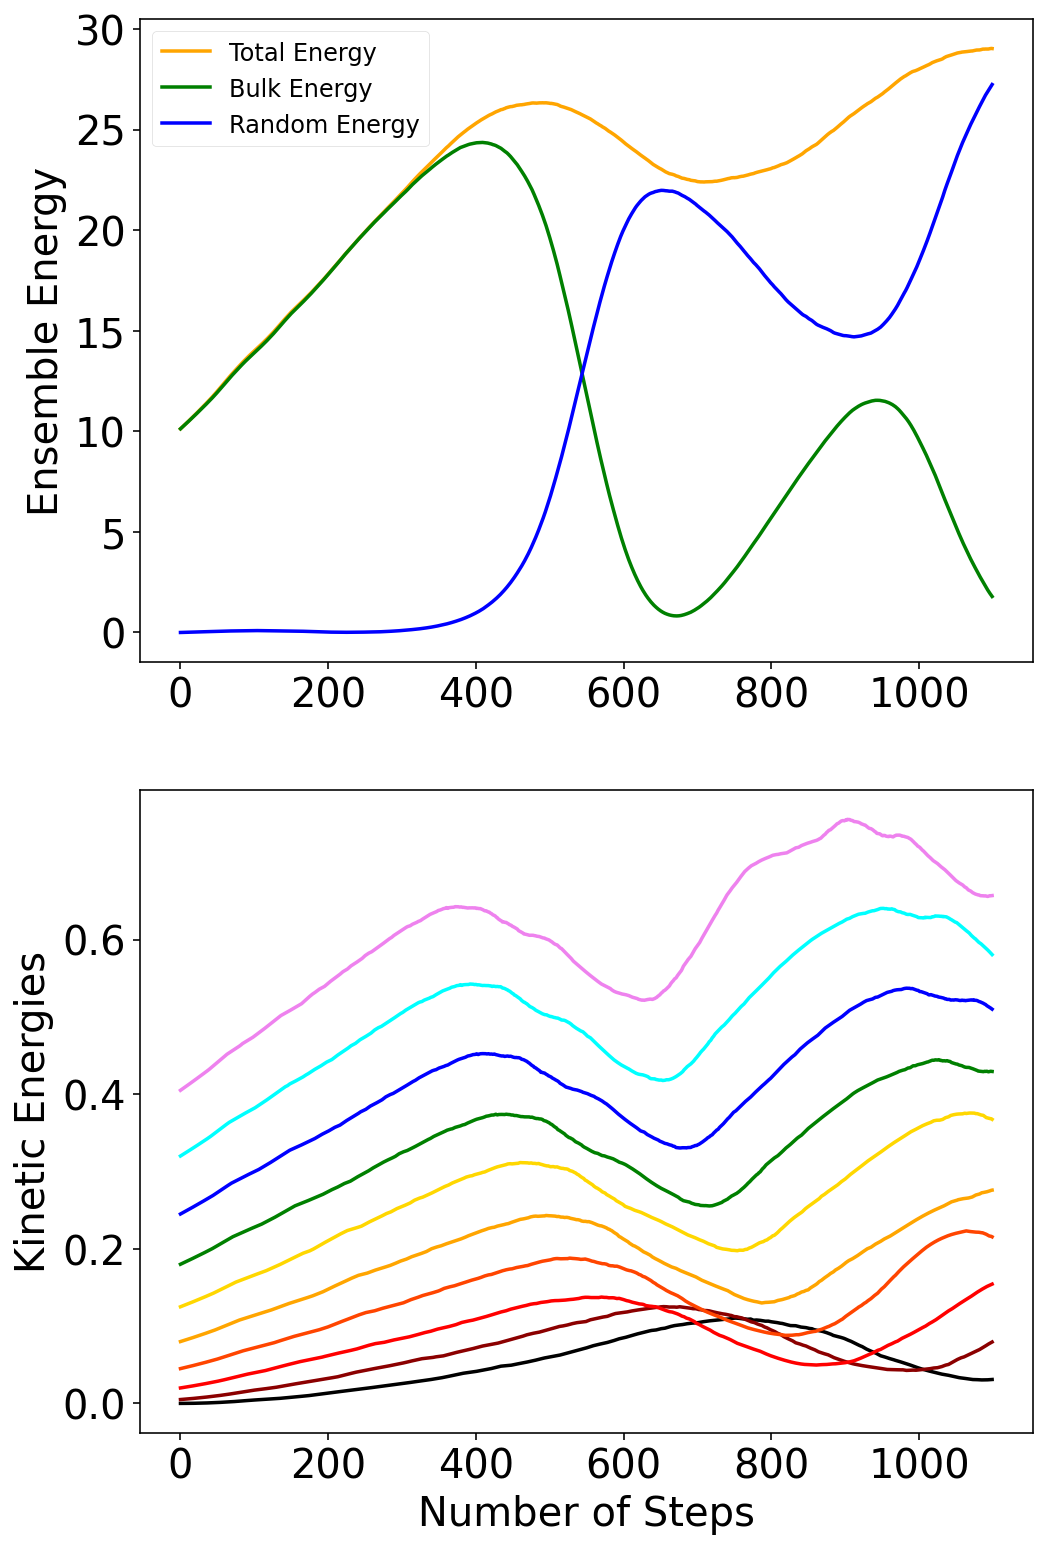

In [88]:
fnt = 20
end  = 1100


colors = ['black', 'darkred', 'red', 'orangered', 'orange','gold','green', 'blue', 'cyan', 'violet']
list = [k, k1, k2, k3, k4, k5, k6, k7, k8, k9]
    


    


fig, axs = plt.subplots(2,figsize = (8,13))
axs[0].plot(p_avg[0:end],'orange', label = 'Total Energy') #)
axs[0].plot(mag_vec_avg[0:end],'green', label = 'Bulk Energy')
axs[0].plot(p_avg[0:end] - mag_vec_avg[0:end],'blue', label = 'Random Energy' )  # "Random" Energy
axs[0].legend(loc = 'upper left', prop={'size': 12})

axs[0].set_ylabel('Ensemble Energy', fontsize = fnt)


for i in range(0,len(list)):
  
    axs[1].plot(list[i][0:end], color = colors[i])
    #axs[2].plot(list[i][0:end] - list[i][0], colors[i])
    

  

    


axs[1].set_xlabel("Number of Steps", fontsize = fnt)
axs[1].set_ylabel('Kinetic Energies', fontsize = fnt)
axs[1].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='x', labelsize=20)
axs[1].tick_params(axis='y', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)


#axs[2].set_ylabel("Change in Kinetic Energy")
#axs[2].set_xlabel("Number of Steps", fontsize = fnt)


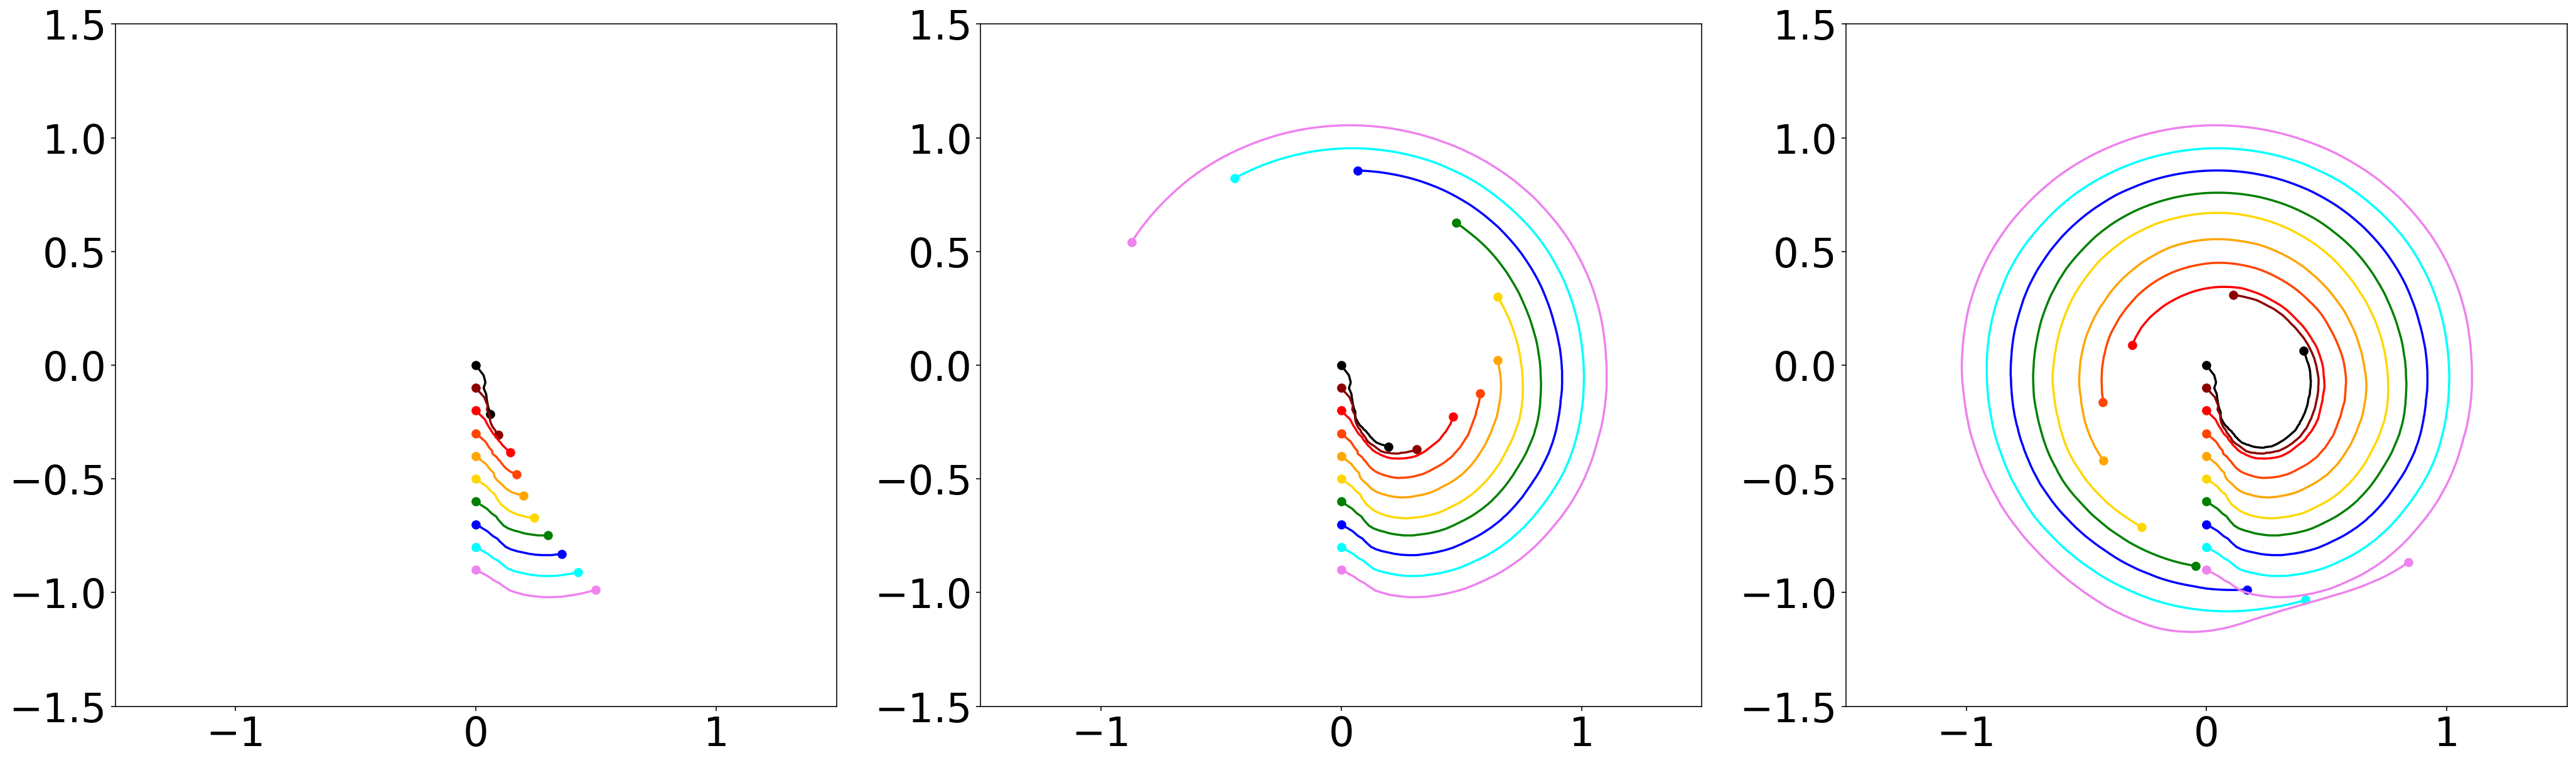

In [90]:

colors = ['black', 'darkred', 'red', 'orangered', 'orange','gold','green', 'blue', 'cyan', 'violet']
list = [p, p1, p2, p3, p4, p5, p6, p7, p8, p9]

end1 = 300
end2 = 600
end3 = 900
#end4 = 900


fnt = 32
fig, axs = plt.subplots(1,3 ,figsize = (35,10))

for i in range(0,len(list)):
    axs[0].scatter(list[i][0][0],list[i][0][1], color = colors[i])
    axs[0].scatter(list[i][end1][0],list[i][end1][1], color = colors[i])
    axs[0].plot(list[i][:end1,0],list[i][:end1,1], color = colors[i])

    axs[1].scatter(list[i][0][0],list[i][0][1], color = colors[i])
    axs[1].scatter(list[i][end2][0],list[i][end2][1], color = colors[i])
    axs[1].plot(list[i][:end2,0],list[i][:end2,1], color = colors[i])

    axs[2].scatter(list[i][0][0],list[i][0][1], color = colors[i])
    axs[2].scatter(list[i][end3][0],list[i][end3][1], color = colors[i])
    axs[2].plot(list[i][:end3,0],list[i][:end3,1], color = colors[i])

    #axs[3].scatter(list[i][0][0],list[i][0][1], color = colors[i])
    #axs[3].scatter(list[i][end4][0],list[i][end4][1], color = colors[i])
    #axs[3].plot(list[i][:end4,0],list[i][:end4,1], color = colors[i])

    
#axs[0].set_ylabel('Ensemble Energy', fontsize = fnt)


#for i in range(0,len(list)):
  
#    axs[1].plot(list[i][0:end], color = colors[i])
    #axs[2].plot(list[i][0:end] - list[i][0], colors[i])
    

for i in range(3):
    axs[i].set_xlim(-1.5,1.5)
    axs[i].set_ylim(-1.5,1.5)
    axs[i].tick_params(axis='x', labelsize=fnt)
    axs[i].tick_params(axis='y', labelsize=fnt)
    #axs[i].set_xlabel("vL", fontsize = fnt)
    #axs[i].set_ylabel("vM", fontsize = fnt)

#axs[1].set_xlabel("Number of Steps", fontsize = fnt)
#axs[1].set_ylabel('Kinetic Energies', fontsize = fnt)

